### Working with spatial data - maps


Any transportation network can be represented as a complex directed graph where vertices are spread an Euclidean space. This makes it possible to run real-life-sized experiment on transportation networks along with various visualizations.

Preparation of this workshop has been supported by the Polish National Agency for Academic Exchange<br>
under the Strategic Partnerships programme, grant number BPI/PST/2021/1/00069/U/00001


Firstly, let us start by installing the required Julia and Python packages. (If the packages are required uncomment the code below)

In [1]:
using Random
using OpenStreetMapX
using Plots
ENV["GKSwstype"]="nul"
gr()
using OpenStreetMapXPlot
using Graphs
using Colors
using PythonCall 

const flm = pyimport("folium");

In [3]:
println(pwd())  # use this to to check in which folder you are, the folder should contain the torontoF.osm file

C:\AAABIBLIOTEKA\NAWA_ed2\2024_Julia_optimization_models_in_logistics\3_Working_with_maps


We start by loading the file. Note that we trim the map file to have a fully connected road network.

> The file was downloaded from the [OpenStreetMap](https://www.openstreetmap.org/) project web page. The steps included: (1) Select some area on map; (2) Click the "Export" button at the top of the page; (3) Click "Manually select a different area" to select the central Toronto area; (4) Press the "Export" button on the left (note that sometimes the Export link does not work - in this case click one of the Overpass API link below the Export button).



In [4]:
m = get_map_data("../mokotow.osm", use_cache=false, trim_to_connected_graph=true );

The central element of the `MapData` object is a `Graphs.jl`' representation of the road network

In [5]:
m.g

{2180, 4322} directed simple Int64 graph

The Graphs.jl graph is represented by nodes, each node id can be directly mapped to OpenStreetMap. 

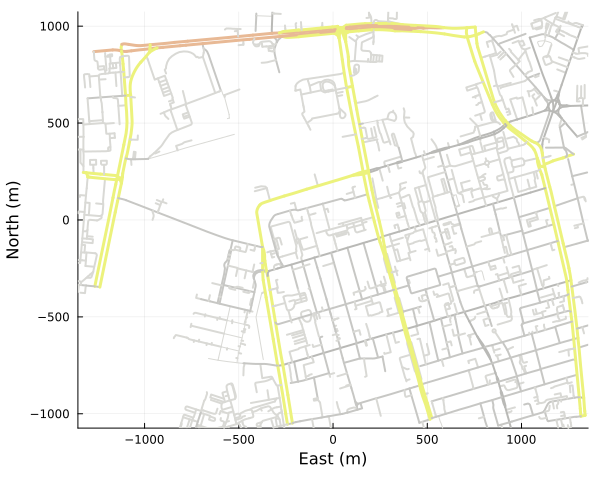

In [6]:
plotmap(m)

Let's consider a fleet of 10 vehicles an let them walk between randomly selected pairs of points

In [9]:
Random.seed!(0)
routes = Vector{Int}[]
for k in 1:10
    startA, endB = rand(1:nv(m.g), 2)
    route, route_time = OpenStreetMapX.shortest_route(m,m.n[startA],m.n[endB])
    push!(routes, route)
end

Now we will plot those routes 

In [11]:
fm = flm.Map()
colrs = distinguishable_colors(10, [RGB(1,0.6,0.5)])
for k=1:4
    locs = [LLA(m.nodes[n],m.bounds) for n in routes[k]]
    info = "The route of Car $k\n<BR>"*
        "Length: $(length(routes[k])) nodes\n<br>" *
        "From: $(routes[k][1]) $(round.((locs[1].lat, locs[1].lon),digits=4))\n<br>" *
        "To: $(routes[k][end]) $(round.((locs[end].lat, locs[end].lon),digits=4))"
    flm.PolyLine(
        [(loc.lat, loc.lon) for loc in locs ],
        popup=info,
        tooltip=info,
        color="#$(hex(colrs[k]))"
    ).add_to(fm)
end

MAP_BOUNDS = ((m.bounds.min_y,m.bounds.min_x),(m.bounds.max_y,m.bounds.max_x))
flm.Rectangle(MAP_BOUNDS, color="black",weight=6).add_to(fm)
fm.fit_bounds(MAP_BOUNDS)
fm

Python: <folium.folium.Map object at 0x0000023077180470>

Let now us try to built a simple model of vehicle fleet driving around the city

In [13]:
struct OSMXPos
    node1::Int # starting node
    node2::Int # target node (if it is equal to node1 the agent
               # makes decision on the next step)
    trav::Float64 #travelled %
end  # position of a vehicle

In [14]:
# helper constructors for representation of movement
OSMXPos(node1::Int, node2::Int) = OSMXPos(node1, node2, 0.0) #agent decided to head to node 2
OSMXPos(node::Int) = OSMXPos(node, node) # agent arrived to node
function OSMXPos(pos::OSMXPos, delta::Float64)
    trav = pos.trav + delta
    trav >= 1.0 && return OSMXPos(pos.node2)
    trav <= 0.0 && return OSMXPos(pos.node1)
    return OSMXPos(pos.node1, pos.node2, trav)
end

OSMXPos

We move to a definition of a `Vehicle`

In [16]:
@kwdef mutable struct Vehicle
    id::Int
    pos::OSMXPos
    #travel plan
    path::Dict{Int,Int} = Dict{Int,Int}() #seqence of nodes  1=>2,  2=>7, 7 => 12
    path_distances::Dict{Int,Float64} = Dict{Int,Float64}() # 100m    400m  500m
end
Vehicle(id,pos)=Vehicle(id=id,pos=pos) #additional constructor

Vehicle

Once the vehicle is defined let us define the enviroment where they can move around.

In [31]:
@kwdef struct Simulation
    vehicles::Vector{Vehicle}
    m::MapData
end

# constructor - simulation initializer
function Simulation(m::MapData, N=15)
    vv = nv(m.g) # number of vertices
    vehicles = Vehicle.(1:N, OSMXPos.(rand(1:vv,N)))
    Simulation(; vehicles, m)
end

Simulation

Now we define the plotting function:

In [32]:
# helper functions for location processing
function get_ENU(node::Int, model)
    model.m.nodes[m.n[node]]
end

function get_coordinates(vehicle, model)
    pos1 = get_ENU(vehicle.pos.node1, model)
    pos2 = get_ENU(vehicle.pos.node2, model)
    (getX(pos1)*(1-vehicle.pos.trav)+getX(pos2)*(vehicle.pos.trav),
     getY(pos1)*(1-vehicle.pos.trav)+getY(pos2)*(vehicle.pos.trav))
end

# actual plotting function
function plot_simstate(model, background=Plots.current())
    for vehicle in model.vehicles
        path = [vehicle.pos.node1]
        while path[end] in keys(vehicle.path)
            push!(path, vehicle.path[path[end]])
        end
        length(path) < 2 && continue
        a_x, a_y = get_coordinates(vehicle, model)
        enu_coords = get_ENU.(path[2:end], Ref(model))

        a_x2, a_y2 = (getX(enu_coords[1]), getY(enu_coords[1]))

        !(a_x == a_x2 && a_y == a_y2) &&  plot!(
                background, [a_x, a_x2], [a_y, a_y2],
                color=colorant"blue", arrow =arrow(:open))

        length(enu_coords) > 2 &&  plot!(
                background, getX.(enu_coords),  getY.(enu_coords),
                color=colorant"blue", arrow =arrow(:closed))
    end
    pos = [get_coordinates(vehicle, model) for vehicle in model.vehicles]
    scatter!(background,
        pos;
        markercolor = colorant"red",
        markersize = 6,
        markershapes = :square,
        label = "",
        markerstrokewidth = 0.5,
        markerstrokecolor = :black,
        markeralpha = 0.7,
    )

end

plot_simstate (generic function with 2 methods)

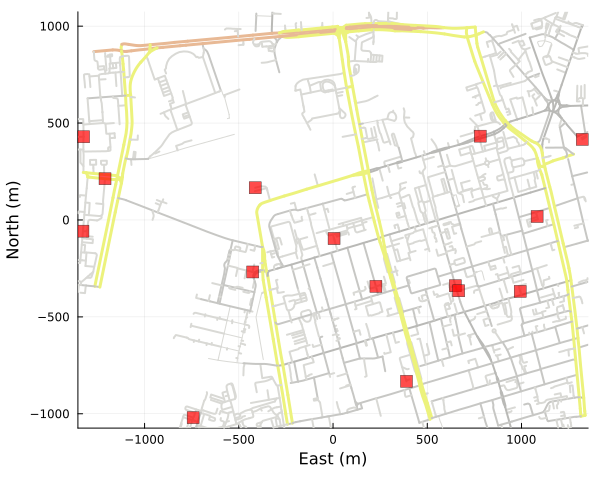

In [33]:
s=Simulation(m)
plotmap(s.m)
plot_simstate(s)

Now we need to define how the vehicles move around

In [34]:
function move_vehicle!(vehicle, model; meters=50.0)
    if vehicle.pos.node1 == vehicle.pos.node2
        #selecting new travel destination if none exists
        if ! (vehicle.pos.node1 in keys(vehicle.path))
            nodes = Int[]
            while length(nodes) < 2
                n2 = rand(1:nv(model.m.g))
                nodes =  getindex.(Ref(model.m.v),
                        shortest_route(model.m,model.m.n[vehicle.pos.node1],
                                       model.m.n[n2])[1])
            end
            empty!(vehicle.path)
            setindex!.(Ref(vehicle.path), nodes[2:end], nodes[1:end-1])
            for i in 1:(length(nodes)-1)
                vehicle.path_distances[nodes[i]] = model.m.w[nodes[i], nodes[i+1]]
            end
        end
        node2 = vehicle.path[vehicle.pos.node1]
        trav = meters/vehicle.path_distances[vehicle.pos.node1]
        if trav >= 1.0
            pos = OSMXPos(node2)
        else
            pos = OSMXPos(vehicle.pos.node1, node2, trav)
        end
    else
        pos = OSMXPos(vehicle.pos, meters/vehicle.path_distances[vehicle.pos.node1])
    end
    vehicle.pos = pos
end


move_vehicle! (generic function with 1 method)

Having moevment function defined we can define the step function.

In [35]:
function step!(model)
    for vehicle in model.vehicles
        move_vehicle!(vehicle, model; meters=50.0)
        #todo : do something eg. deliver a parcel ;)
    end
end

step! (generic function with 1 method)

We run the simulation for 30 steps and watch the result

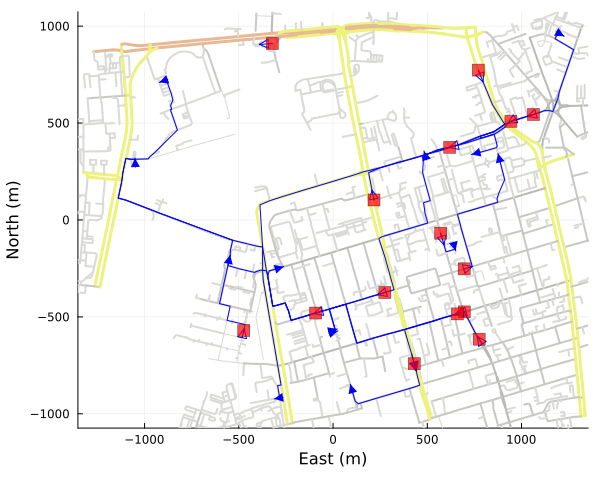

In [36]:
overl = plotmap(s.m) # overlay map to speed up plotting
Random.seed!(1)
s = Simulation(m)
for i in 1:30
    step!(s)
end

plot_simstate(s, deepcopy(overl))

[ Info: Saved animation to C:\AAABIBLIOTEKA\NAWA_ed2\2024_Julia_optimization_models_in_logistics\3_Working_with_maps\tmp.gif


Plots.AnimatedGif("C:\\AAABIBLIOTEKA\\NAWA_ed2\\2024_Julia_optimization_models_in_logistics\\3_Working_with_maps\\tmp.gif")
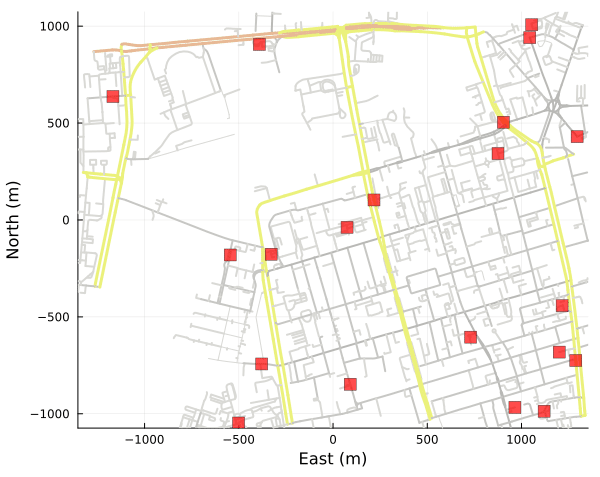

In [39]:
Random.seed!(1)
s = Simulation(m, 20)
p = plotmap(s.m)
Plots.@gif for i in 1:150
    i > 1 && step!(s)
    plot_simstate(s, deepcopy(p))
end